# Basic Speech Recognition

## Project on identifying number, tone-of-voice, and participant from human audio samples.


# Environment set-up
## Libraries
Import necessary libraries in colab or local

In [ ]:
# local
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa, librosa.display

In [ ]:
# colab
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa, librosa.display
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data 

Data for this project needs to be downloaded from QMUL. One file contains the audio clips and the other has the correct labels for these clips.

In [ ]:
def download_url(url, save_path):
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())

url  = "https://collect.qmul.ac.uk/down?t=6H8231DQL1NGDI9A/613DLM2R3OFV5EEH9INK2OG"
save_path = './Data/training.zip'
download_url(url, save_path)

directory_to_extract_to = './Data/training/'
with zipfile.ZipFile(save_path, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

# Section 1: Basic Solution

This basic solution tackles the machine learning problem of identifying or classifying the intonation of various audio samples of digits recorded by participants. There are four intonation types: neutral, bored, excited, question. To do this, various models will be built and tested using the MLEnd dataset. This solution will cover the process of preparing, visualising, and preprocessing the dataset so it is fit for training models with, and will then cover how two models trained on the dataset, a support vector machine and random forest decision tree algorithm, perform and compare with each other using a validation data-subset. This process includes identifying the four best features from eleven, to use as predictors, through feature selection. Both models achieved similar overall validation accuracies of around 54%, which is over twice as good as guessing. 

## Dataset Preparation

After ensuring all the necessary datasets are downloaded, load them as variables to allow for manipulation later on.

In [ ]:
# local
files = glob.glob('./Data/training/training/*.wav')
labels = pd.read_csv('./Data/trainingMLEnd.csv')

In [ ]:
# colab
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/Training/*.wav')
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')

## Dataset Visualisation

This section will focus on the visualistion of the dataset and individual audio samples through graphical representation of the relevant information/data. By using visual elements like charts, graphs, and maps, data visualisation tools provide an accessible way to see and understand trends, outliers, and patterns in data. This is useful as it can help guide the data preprocessing stage later.


Simple waveform of an audio sample. The sample consists mainly of regions with negligible amplitude (silence), with the voiced region being the part with noticeable amplitude. Not every sample is guaranteed to look similar.

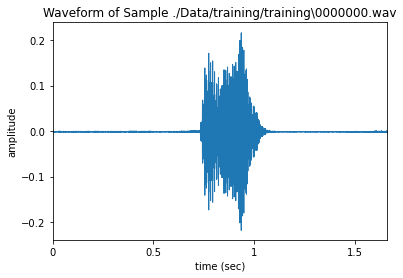

In [ ]:
n=0
signal, fs = librosa.load(files[n])
librosa.display.waveplot(signal, sr=fs)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.title(f'Waveform of Sample {files[n]}')
plt.show()
display(ipd.Audio(files[n]))

Power spectrum of above sample. The majority of the power lies in the lower frequencies of speech.

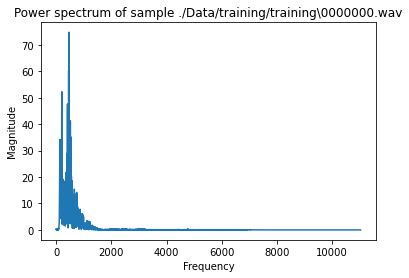

In [ ]:
fft = np.fft.fft(signal)
spectrum = np.abs(fft)
f = np.linspace(0, fs, len(spectrum))
half_spectrum = spectrum[:int(len(spectrum)/2)]
half_f = f[:int(len(spectrum)/2)]

plt.plot(half_f, half_spectrum)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title(f"Power spectrum of sample {files[n]}")
plt.show()

Bar chart showing the frequency/occurrence of each intonation type in the dataset. As shown, this dataset is balanced as there is an equal number of each label (intonation type). This is a good indication that models will not be biased towards any one intonation.

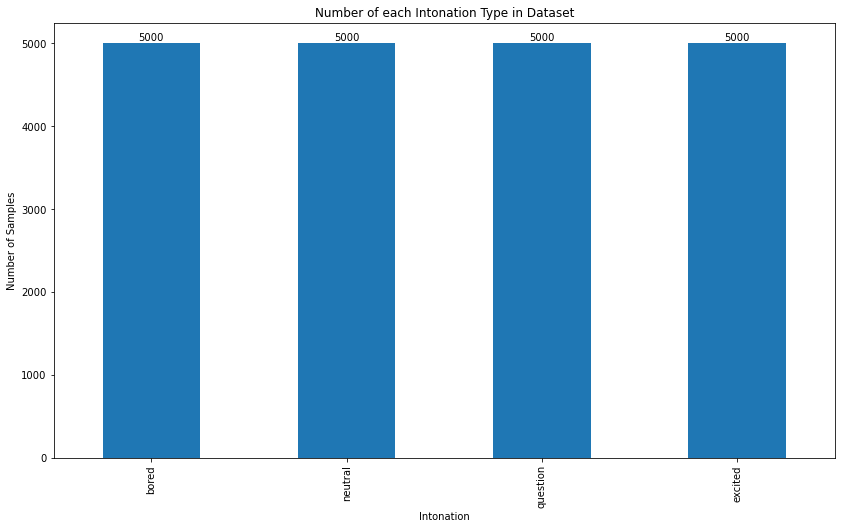

In [ ]:
values = labels['intonation'].value_counts()
ax = values.plot(kind='bar',figsize=(14,8),title="Number of each Intonation Type in Dataset")
plt.xlabel("Intonation")
plt.ylabel("Number of Samples")

rects = ax.patches

for rect, label in zip(rects, values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')


Distribution of audio sample durations. The majority of audio clips are between 1 and 2 seconds in length, but a few have lengths exceeding this, with some even eclipsing 10 seconds. Most likely, these either will consist of mainly empty regions, or will contain multiple voiced regions due to sub-optimal audio cutting. Longer samples may disrupt model training by affecting certain extracted features.

In [ ]:
def duration(input):
  duration=[]
  for file in input:
    sample,fs = librosa.load(file)
    duration.append(float(len(sample)/fs))
  return duration

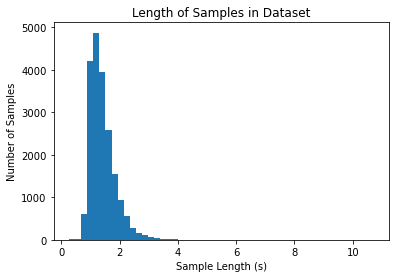

In [ ]:
dur=duration(files)
plt.hist(np.array(dur),bins=50)
plt.title("Length of Samples in Dataset")
plt.xlabel("Sample Length (s)")
plt.ylabel("Number of Samples")
plt.show()

## Data Preprocessing

This section will manipulate, process, and extract features from the data in the datasets such that the data are ready for models to be trained on. This will include identifying the most important features of the dataset, through feature selection.

Trimming dataset to only include files shorter than 3 seconds. This should help prevent skewing extracted features due to empty regions/multiple voiced regions.

In [ ]:
def shorten(input,time):
    short=input
    for file in short:
        sample,fs = librosa.load(file)
        if len(sample)/fs > time:
            short.remove(file)
    return short

In [ ]:
files=shorten(files,3)
print(len(files))

19843


Encode and display intonation labels such that models can be trained on them.

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# track how encoding mapping looks like
le.fit(labels['intonation'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# add encoded version of intonation to dataframe
labels['intonation_encoded'] = le.fit_transform(labels['intonation'])

print(le_name_mapping)
labels

{'bored': 0, 'excited': 1, 'neutral': 2, 'question': 3}


File ID  digit_label participant intonation  intonation_encoded
0      0000000.wav            4         S73   question                   3
1      0000001.wav            2         S88    excited                   1
2      0000002.wav           70          S5    neutral                   2
3      0000003.wav            2         S85      bored                   0
4      0000004.wav            4         S30    excited                   1
...            ...          ...         ...        ...                 ...
19995  0019995.wav           90        S163    excited                   1
19996  0019996.wav           10         S99   question                   3
19997  0019997.wav           90         S46   question                   3
19998  0019998.wav           19         S13    neutral                   2
19999  0019999.wav           20        S101    neutral                   2

[20000 rows x 5 columns]

Feature extraction is necessary as the models will require predictors to be trained on. 

Define a function(s) to extract the following features from the audio samples:

* Mel-frequency cepstrum coefficient (mfcc)
* Spectral centroid
* Spectral bandwidth
* Spectral rolloff
* Chroma feature short-time fourier transform (chroma stft)
* Zero crossing rate (zcr)
* Root mean square (rms)
* Pitch
* Pitch mean
* Pitch standard deviation
* Power



In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [ ]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file[-11:]
    yint = list(labels_file[labels_file['File ID']==fileID]['intonation_encoded'])[0]
    ydig = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    if onlySingleDigit and ydig>9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)

      # features
      mfcc = librosa.feature.mfcc(y=x, sr=fs)
      spec_cent = librosa.feature.spectral_centroid(y=x, sr=fs)
      chroma_stft = librosa.feature.chroma_stft(y=x, sr=fs)
      zcr = librosa.feature.zero_crossing_rate(x)
      rms = librosa.feature.rms(y=x)
      rolloff = librosa.feature.spectral_rolloff(y=x, sr=fs)
      spec_bw = librosa.feature.spectral_bandwidth(y=x, sr=fs)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)

      xi = [np.mean(mfcc),np.mean(spec_cent),np.mean(spec_bw),np.mean(rolloff),np.mean(zcr),np.mean(rms),np.mean(chroma_stft),power,pitch_mean,pitch_std,voiced_fr]
      X.append(xi)
      y.append(yint)
  return np.array(X),np.array(y)

### Feature Selection

This section will explore the process of selecting the features with the greatest importance to classification for use in the models later on. Two apporaches will be taken: feature scoring using multinomial logistic regression and using random forest. In total, 11 features will be evaluated, and the ones with the highest importance weighting will then be taken forward for model training. This is done as some predictors may not be meaningful, having too many predictors may result in some redundancy between them, and in many other scenarios collecting enough data for 11 features may not be feasible. Feature evaluation will be performed on roughly a quarter of the audio samples to prevent overfitting and to save time.

In [ ]:
# get the predictors and labels

X,y = getXy(sfiles[:5000],labels_file=labels,scale_audio=True, onlySingleDigit=False)

  8%|▊         | 412/5000 [01:50<20:53,  3.66it/s]C:\Coding\Anaconda\envs\MLEnd\lib\site-packages\librosa\core\pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
100%|██████████| 5000/5000 [24:48<00:00,  3.36it/s]


#### Logistic regression

Multinomial logistic regression is a popular machine learning algorithm that is often used when classifying categorical dependent variables. This method will provide a crude estimate of each feature's importance and requires the features to be scaled or normalised.

Feature: 1, Score: 0.13097
Feature: 2, Score: -0.83435
Feature: 3, Score: -0.25547
Feature: 4, Score: 0.95938
Feature: 5, Score: 0.13547
Feature: 6, Score: 0.20405
Feature: 7, Score: -0.07160
Feature: 8, Score: 0.12575
Feature: 9, Score: -0.25502
Feature: 10, Score: -1.87278
Feature: 11, Score: 0.19172


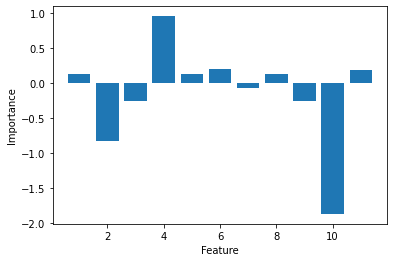

In [ ]:
# logistic regression for feature scoring
from sklearn.linear_model import LogisticRegression

# normalise X
mean = X.mean(0)
sd =  X.std(0)
X_norm = (X-mean)/sd

# define the model with multi_class and a solver that supports multi_class
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# fit the model
logreg.fit(X_norm, y)

# get importance
importance_reg = logreg.coef_[0]

# summarize feature importance
for i,v in enumerate(importance_reg):
	print('Feature: %0d, Score: %.5f' % (i+1,v))
	
# plot feature importance
plt.bar([x+1 for x in range(len(importance_reg))], importance_reg)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

#### Random Forest 

Random forest algorithms are ensemble learning methods that build decision trees for classification. This is a slightly more robust method for weighing the importance of each feature.

Feature: 1, Score: 0.08135
Feature: 2, Score: 0.06428
Feature: 3, Score: 0.07066
Feature: 4, Score: 0.06394
Feature: 5, Score: 0.06662
Feature: 6, Score: 0.07795
Feature: 7, Score: 0.07765
Feature: 8, Score: 0.07106
Feature: 9, Score: 0.12308
Feature: 10, Score: 0.21831
Feature: 11, Score: 0.08510


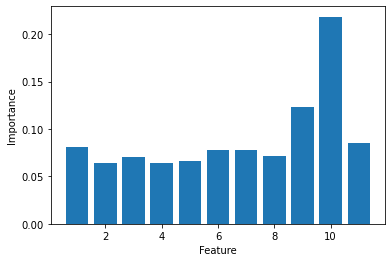

In [ ]:
# random forest for feature importance on a classification problem
from sklearn.ensemble import RandomForestClassifier

# define the model
forest = RandomForestClassifier()

# fit the model
forest.fit(X_norm,y)

# get importance
importance_rf = forest.feature_importances_

# summarize feature importance
for i,v in enumerate(importance_rf):
	print('Feature: %0d, Score: %.5f' % (i+1,v))
	
# plot feature importance
plt.bar([x+1 for x in range(len(importance_rf))], importance_rf)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

Analysis

From the feature selection methods, it is evident that the 10th feature, pitch standard deviation, has been weighed as most important, by a large margin, by both methods. Looking at the results from logistic regression, rolloff and spectral centroid came in second and third, while pitch mean and mfcc/fraction of voiced region took those places for random forest. Since fraction of voiced region depends heavily on how the audio samples were cut (of which some have been cut better than others), this feature will be discarded. As such, leaning in favour of the random forest results, the pitch std, pitch mean, mfcc and spectral rolloff will be taken forward.

#### Additional Data Preprocessing after Feature Selection

Having identified which features to take forward, these features will now be re-extracted from the data for simplicity. Define an updated function for feature extraction:

In [ ]:
def getXy_v1(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file[-11:]
    yint = list(labels_file[labels_file['File ID']==fileID]['intonation_encoded'])[0]
    ydig = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    if onlySingleDigit and ydig>9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)

      # features - only those selected as most important
      mfcc = librosa.feature.mfcc(y=x, sr=fs)
      rolloff = librosa.feature.spectral_rolloff(y=x, sr=fs)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0

      xi = [np.mean(mfcc),np.mean(rolloff),pitch_mean,pitch_std]
      X.append(xi)
      y.append(yint)
  return np.array(X),np.array(y)

 Only 3/4 of the dataset was used to save time processing.

In [ ]:
# get the updated predictors and labels

X,y = getXy_v1(files[:15000],labels_file=labels,scale_audio=True, onlySingleDigit=False)

100%|██████████| 15000/15000 [57:34<00:00,  4.34it/s]


Normalise X. The goal of data normalisation is to change the values of the data in the datasets to use a common scale, without distorting differences in the ranges of values or losing information. Normalisation is also required for some algorithms to model the data correctly.

In [ ]:
mean = X.mean(0)
sd =  X.std(0)

X_norm = (X-mean)/sd

Having obtained and normalised the updated predictors and labels, these now need to split into training and validation subsets for use in model training and validation in the next section. 30% of the predictors and labels will be used for validation.

In [ ]:
from sklearn.model_selection import train_test_split

# split into training and validation subsets
X_train, X_val, y_train, y_val = train_test_split(X_norm,y,test_size=0.3, shuffle=True)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((10500, 4), (4500, 4), (10500,), (4500,))

## Models

This section will cover the building, training, and validation of two models on the datasets: a support vector machine and a random forest decision tree. Confusion matrices and receiver operating characteristic (ROC) curves will be used to evaluate the performance of each model. Finally, model accuracies will be compared.

### Support Vector Machine

This first model is a support vector machine (svm), which is a supervised learning method. They are a popular choice for classification and regression problems and perform well in high dimensional spaces, even when the number of dimensions is greater than the number of samples. Here, the svm will be tuned on two hyperperameters.

Tuning gamma as a hyperparameter.

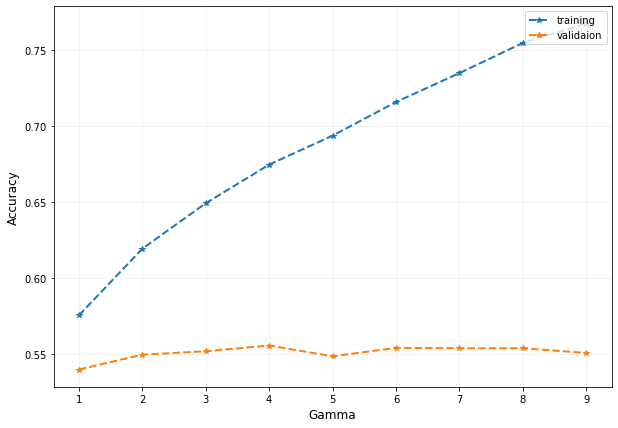

In [ ]:
from sklearn import svm

gamma_values = range(1,10,1)

# create dictionary of accuracy values
accuracy_train = dict.fromkeys(gamma_values)
accuracy_val = dict.fromkeys(gamma_values)

for value in gamma_values:

    # define the svm model - needs to be named differently to svm to prevent overwriting
    svmodel = svm.SVC(C=1,gamma=value)
    svmodel.fit(X_train,y_train)

    # calculate and track the training and validation accuracy
    y_train_pred = svmodel.predict(X_train)
    accuracy_train[value] = np.mean(y_train==y_train_pred)

    y_val_pred = svmodel.predict(X_val)
    accuracy_val[value] = np.mean(y_val==y_val_pred)

#plot figure of accuracies
plt.figure(figsize=(10, 7))
plt.plot(gamma_values, list(accuracy_train.values()), '--*', linewidth=2, label= 'training')
plt.plot(gamma_values, list(accuracy_val.values()), '--*', linewidth=2, label= 'validaion')
plt.xlabel("Gamma", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(alpha=0.2)
plt.legend(loc='upper right')
plt.show()


Increasing gamma significantly increases the training accuracy of the model, suggesting that tuning this might result in overfitting. This is not the case here though, as increasing gamma has little effect on the validation accuracy - overfitting would expect to see validation accuracy decrease. Gamma = 2 will be taken forward to strike a balance between slightly better training and validation accuracy, and mitigating any potential overfitting.

Tuning C as a hyperparameter.

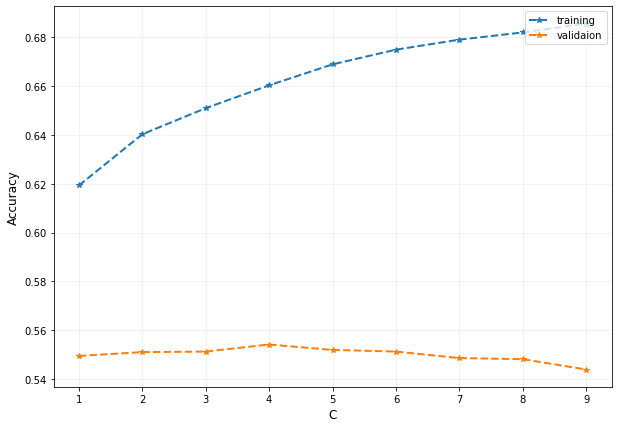

In [ ]:
C_values = range(1,10,1)

# create dictionary of accuracy values
accuracy_train = dict.fromkeys(C_values)
accuracy_val = dict.fromkeys(C_values)

for value in C_values:

    # define the svm model - needs to be named differently to svm to prevent overwriting
    svmodel = svm.SVC(C=value,gamma=2)
    svmodel.fit(X_train,y_train)

    # calculate and track the training and validation accuracy
    y_train_pred = svmodel.predict(X_train)
    accuracy_train[value] = np.mean(y_train==y_train_pred)

    y_val_pred = svmodel.predict(X_val)
    accuracy_val[value] = np.mean(y_val==y_val_pred)

#plot figure of accuracies
plt.figure(figsize=(10, 7))
plt.plot(C_values, list(accuracy_train.values()), '--*', linewidth=2, label= 'training')
plt.plot(C_values, list(accuracy_val.values()), '--*', linewidth=2, label= 'validaion')
plt.xlabel("C", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(alpha=0.2)
plt.legend(loc='upper right')
plt.show()

Similar to gamma, C had little impact on validation accuracy, but increasing C did increase training accuracy. After C=4, the validation accuracy does slowly decrease, perhaps suggesting overfitting, but due to the small scale of the accuracy change, this could be due to randomness in the validation subset. C=2 will be taken forward to strike a balance between slightly better training and validation accuracy, and mitigating any potential overfitting.

#### Confusion Matrix

The confusion matrix is a good tool for visualising the rate at which the model is correctly or incorrectly classifying samples. If misclassified, the matrix will show which label the sample was classified as.

The confusion matrices have been normalised across the true labels such that the values on the diagonal (top left to bottom right) are the true positive rates or sensitivity.

mapping:  {'bored': 0, 'excited': 1, 'neutral': 2, 'question': 3}


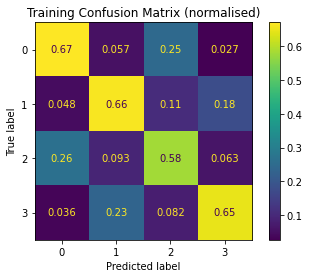

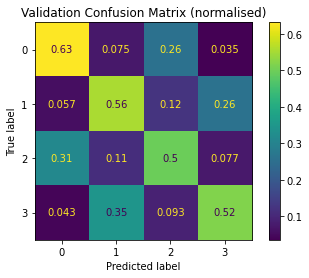

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# label encoding reminder
print('mapping: ', le_name_mapping)

# define and build optimal model
svm_best = svm.SVC(C=2,gamma=2)
svm_best.fit(X_train,y_train)

# plot confusion matrices
plot_confusion_matrix(svm_best, X_train, y_train, normalize='true')
plt.title('Training Confusion Matrix (normalised)')
plt.show()

plot_confusion_matrix(svm_best, X_val, y_val, normalize='true')
plt.title('Validation Confusion Matrix (normalised)')
plt.show()

These matrices show that this model has decent validation true postive rates, all of which are above 50%. Interestingly, this shows that the model most often misclassified bored with neutral intonations and vice versa, with the same true for excited and question intonations. This makes sense from a human perspective, as each pair mentioned sound somewhat alike. Bored was the intonation that most easily classified in both training and validation.

#### ROC

The receiver operating characteristic is a tool for measuring the ability of a model to make a binary classification. Since this is a multi-class problem, the ROC curve will take a one vs rest approach: either a sample is correctly or incorrectly classified. The area under the graph (AUC) is a measure of how well the model can classify samples as a label in a binary fashion. A value of AUC=1 is the best. If the ROC curve is lose to the diagonal dashed line, then the model is comparible to one that merely guesses the label.

Define a function to build multi-class ROC curves.

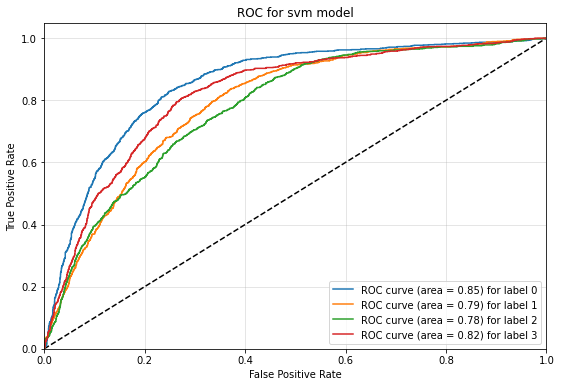

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc

# define function
# n_classes is number of unique labels
def plot_multiclass_roc(model, X_test, y_test, n_classes, figsize, modeltype):

    # each model uses a different decision function
    if modeltype == 'rf':
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC for {modeltype} model')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="lower right")
    ax.grid(alpha=.4)
    plt.show()

# plot ROC curve
plot_multiclass_roc(svm_best, X_val, y_val, n_classes=4, figsize=(9, 6), modeltype='svm')

The ROC curves shows that this model has decent discrimination for all intonations, particularly for bored.  

### Random Forest

As mentioned earlier, random forest algorithms are ensemble learning methods that build decision trees for classification. They can be prone to overfitting on the training data. Here, one hyperperameter is tuned.

Tuning n estimators/tree depth as a hyperparameter.

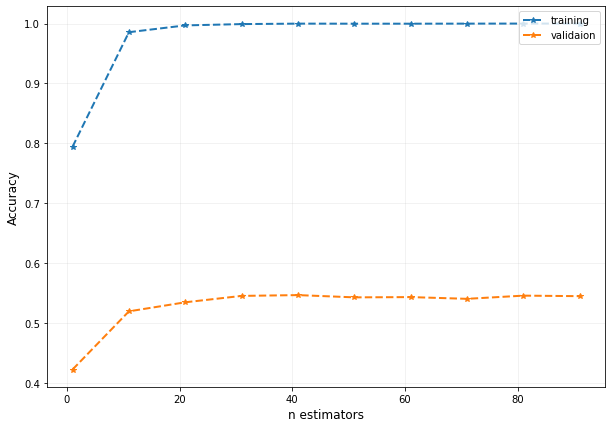

In [ ]:
from sklearn.ensemble import RandomForestClassifier

n_values = range(1,100,10)

# create dictionary of accuracy values
accuracy_train = dict.fromkeys(n_values)
accuracy_val = dict.fromkeys(n_values)

for value in n_values:

    # define the random tree model
    rf = RandomForestClassifier(n_estimators=value)
    rf.fit(X_train, y_train)

    # calculate and track the training and validation accuracy
    y_train_pred = rf.predict(X_train)
    accuracy_train[value] = np.mean(y_train==y_train_pred)

    y_val_pred = rf.predict(X_val)
    accuracy_val[value] = np.mean(y_val==y_val_pred)

#plot figure of accuracies
plt.figure(figsize=(10, 7))
plt.plot(n_values, list(accuracy_train.values()), '--*', linewidth=2, label= 'training')
plt.plot(n_values, list(accuracy_val.values()), '--*', linewidth=2, label= 'validaion')
plt.xlabel("n estimators", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(alpha=0.2)
plt.legend(loc='upper right')
plt.show()

Initially, as n_estimators is increased, so too do training and validation accuracy. Training accuracy quickly approaches 1 with n, demonstrating how this could be overfitting; however, this does not appear to be the case here, as validation accuracy plateaus around n=40. As such n=40 will be taken forward. Still, reaching a training accuracy of 1 could imply that the tree was able to grow enough such that there is a single data point per leaf.

#### Confusion Matrix

The confusion matrices have been normalised across the true labels.

mapping:  {'bored': 0, 'excited': 1, 'neutral': 2, 'question': 3}


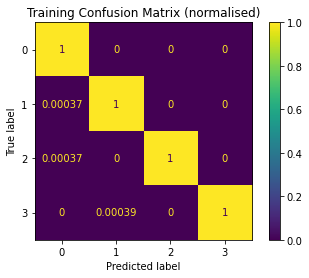

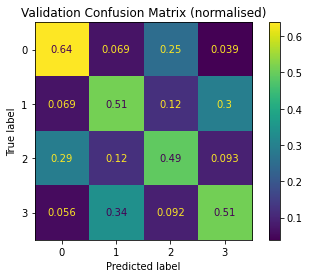

In [ ]:
# label encoding reminder
print('mapping: ', le_name_mapping)

# define and build optimal model
rf_best = RandomForestClassifier(n_estimators=40)
rf_best.fit(X_train,y_train)

# plot confusion matrices
plot_confusion_matrix(rf_best, X_train, y_train, normalize='true')
plt.title('Training Confusion Matrix (normalised)')
plt.show()

plot_confusion_matrix(rf_best, X_val, y_val, normalize='true')
plt.title('Validation Confusion Matrix (normalised)')
plt.show()

The validation matrix shows similar trends to that of the svm model: both bored and neatural, and excited and question were often classified as each other. This time, excited, neutral, and question all had very similar true positive rates.

#### ROC

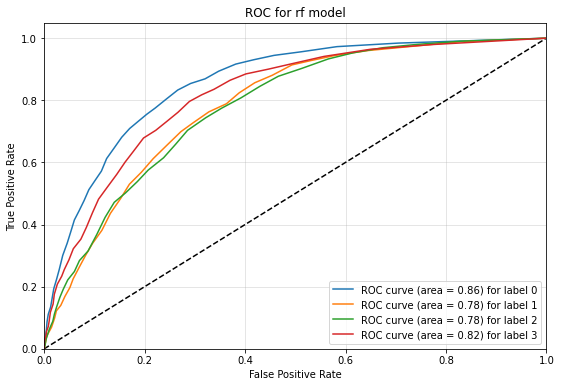

In [ ]:
plot_multiclass_roc(rf_best, X_val, y_val, n_classes=4, figsize=(9, 6), modeltype='rf')

The ROC curves show that this model has decent discriminating ability for each intonation, particularly for bored.

### Comparing Accuracies

Compare the training and validation accuracy for each model.

In [ ]:
# svm
svmpred_t = svm_best.predict(X_train)
svmpred_v = svm_best.predict(X_val)

print('\nSVM training accuracy: ', np.mean(svmpred_t==y_train))
print('SVM validation accuracy: ', np.mean(svmpred_v==y_val))

# random forest
rfpred_t = rf_best.predict(X_train)
rfpred_v = rf_best.predict(X_val)

print('\nrf training accuracy: ', np.mean(rfpred_t==y_train))
print('rf validation accuracy: ', np.mean(rfpred_v==y_val))


SVM training accuracy:  0.6401904761904762
SVM validation accuracy:  0.5511111111111111

rf training accuracy:  0.9997142857142857
rf validation accuracy:  0.5406666666666666


Both models have decent validation accuracies within 0.01 of each other, implying the difference here is likely due to randomness in the validation data-subset.

## Analysis Summary and Conclusion


This basic solution has successfully built and trained two models for digit intonation classification. Looking at the confusion matrices, ROC curves and accuracies for both models, we can see both displayed similar performance. Both models showed good validation accuracies around 54%, and since these were quite close between the models, the differences may in part be due to the nature of the dataset. Had different participants been selected, the model accuracies may have changed. Furthermore, although feature selection was performed and four features taken forward, perhaps a different combination a features, or additional ones, could have benefitted one or both of the models further. Moreover, any audio samples which were not cut correctly could negatively affect training and validation tasks. For example, some samples contained two different participants, or may contain digits with two different intonations, while others may be bad due to poor recording or microphone quality. All of these situations will negatively affect model accuracy. Still, considering guessing the classification of each sample would yield a ~25% accuracy, both models, on average, performed over twice as good as this.

The confusion matrices for both models were also very similar, showing that 'bored' was the most easily classifed label, while 'neutral' was the most difficult. Each model also had validation sensitivities for each label of around 0.55, with the lowest being 0.49 and the highest being 0.64. This is also supported by the ROC curves for both models. With AUCs for all labels around 0.8 +/- 0.07, both models showed a good ability to discriminate. As such, while neither model was outstanding, both provide a decent solution to the classification problem set out at the start.

# Section 2: Advanced Solution

This solution will tackle the machine learning problem of identifying or classifying the participant that recorded an audio sample of a digit - essentially basic voice recognition. This problem will focus on samples from 10 random participants. To do this, various models will be built and tested using the MLEnd dataset. This solution will cover the process of preparing, visualising, and preprocessing the dataset so it is fit for building models with, and will then cover how three models trained on the dataset, a support vector machine, k nearest neighbours and random forest, perform and compare with each other using a validation data-subset. All models showed validation accuracies over 85%, which is 8.5x better than simply guessing.

## Dataset Preparation

This machine learning problem will focus on only 10 participants of the total MLEnd dataset, so only the samples from these 10 participants will be used. Define a function to select only audio samples from these participants. Use random number generator to pick participants.

In [ ]:
# colab
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/Training/*.wav')
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')

In [ ]:
# local
files = glob.glob('./Data/training/training/*.wav')
labels = pd.read_csv('./Data/trainingMLEnd.csv')

Choose participants using a random number generator.

In [ ]:
import random

randomlist = []
for i in range(0,10):
  n = random.randint(1,180)
  randomlist.append(n)
print(randomlist)

[100, 99, 177, 3, 142, 65, 75, 5, 87, 161]


Define a function to aggregate audio samples from selected participants.

In [ ]:
# use random list to update list of participants (rlist)

rlist=['S100','S99','S177','S3','S142','S65','S75','S5','S87','S161']

# define function to select files from participants
def sample_select(files, labels_file, rlist):

    new_files=[]

    for file in files:
        fileID = file[-11:]
        part = list(labels_file[labels_file['File ID']==fileID]['participant'])[0]

        if str(part) in rlist:
          new_files.append(file)
    return new_files
    

Once relevant function is defined, use to parse through total dataset and extract relevant audio samples. New dataset contains 1082 audio samples.

In [ ]:
# make new dataset
new_files = sample_select(files,labels,rlist)

print(len(new_files))

1082


## Data Visualisation

Similar to the basic solution, this section will focus on the visualistion of the dataset and individual audio samples through graphical representation of the relevant information/data. By using visual elements like charts and graphs, data visualisation tools provide an accessible way to see and understand trends in data. This is useful as it can help guide the data preprocessing stage later.

First, an audio sample is selected and the waveform for that sample is shown. The majority of the sample is fairly empty (small wave amplitude is approx. silence), with a defined voiced region. It is not guaranteed all the audio samples look similar: some of the audio samples are better than others. This is likely due to poor microphone qualities/recordings and/or sub-optimal audio sample cutting.  For example, some samples in the whole MLEnd dataset contained two different participants. Any dodgy samples could negatively affect model training or validation.



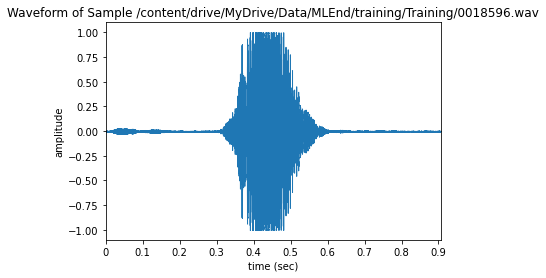

In [ ]:
# change n to change audio sample
n=0
signal, fs = librosa.load(new_files[n])
librosa.display.waveplot(signal, sr=fs)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.title(f'Waveform of Sample {new_files[n]}')
plt.show()
display(ipd.Audio(new_files[n]))

Power spectrum of above sample. The majority of the power lies in the lower frequencies.

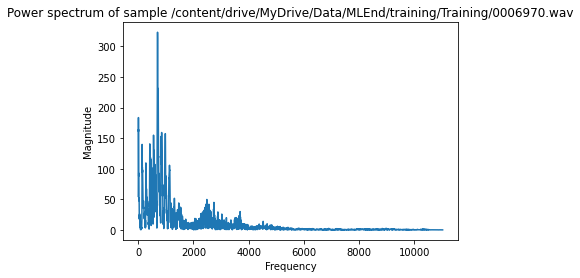

In [ ]:
fft = np.fft.fft(signal)
spectrum = np.abs(fft)
f = np.linspace(0, fs, len(spectrum))
half_spectrum = spectrum[:int(len(spectrum)/2)]
half_f = f[:int(len(spectrum)/2)]

plt.plot(half_f, half_spectrum)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title(f"Power spectrum of sample {files[n]}")
plt.show()

Next, from the 10 participants selected, a bar chart of the number of audio samples per participant is created. As shown, there is a large imbalance between the number of samples of each participant, which could lead to any models trained on this data being biased towards participants with more samples. Furthermore, each participant should have a maximum of 96 samples, meaning either the recorded samples were not cut properly/repeated, or there is some overlap between samples and participants.

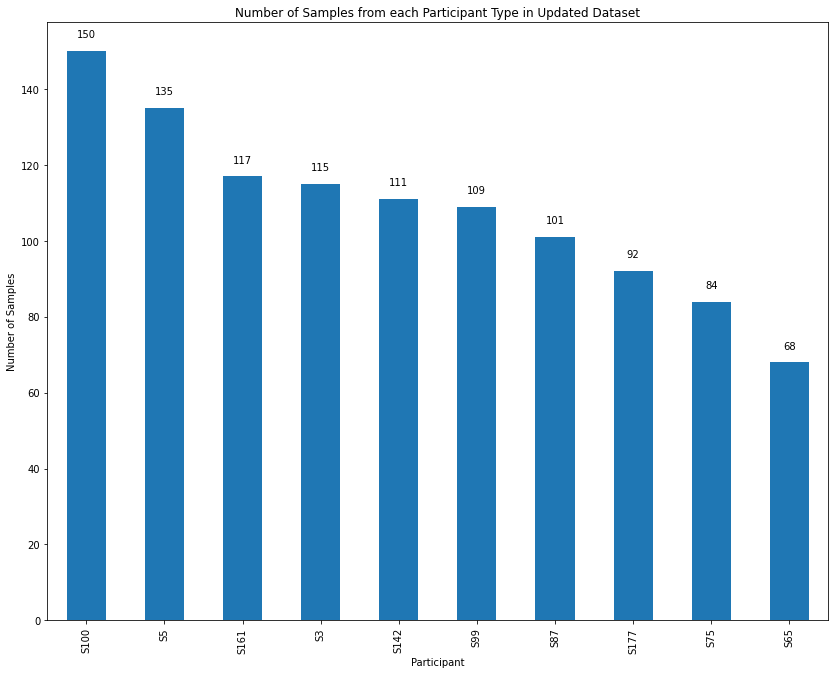

In [ ]:
count_labels=[]

for file in new_files:
        fileID = file[-11:]
        part = list(labels[labels['File ID']==fileID]['participant'])[0]
        count_labels.append(part)

values = pd.Series(count_labels)
values = values.value_counts()
ax = values.plot(kind='bar',figsize=(14,11),title="Number of Samples from each Participant Type in Updated Dataset")
plt.xlabel("Participant")
plt.ylabel("Number of Samples")

rects = ax.patches

for rect, label in zip(rects, values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 3, label,
            ha='center', va='bottom')

Distribution of audio sample durations for the new dataset.  The majority of the samples lie between 1-1.5 seconds, but some are over twice as long. These longer samples may contain a large proportion of empty regions. 

In [ ]:
def duration(input):
  duration=[]
  for file in tqdm(input):
    sample,fs = librosa.load(file)
    duration.append(float(len(sample)/fs))
  return duration

100%|██████████| 1082/1082 [07:01<00:00,  2.57it/s]


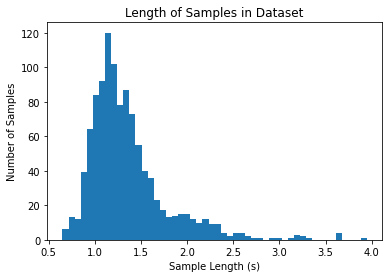

In [ ]:
dur=duration(new_files)
plt.hist(np.array(dur),bins=50)
plt.title("Length of Samples in Dataset")
plt.xlabel("Sample Length (s)")
plt.ylabel("Number of Samples")
plt.show()

## Data Preprocessing

This section will manipulate, process, and extract features from the data in the datasets such that the data are ready for models to be trained on. This will include identifying the most important features of the dataset, through feature selection.

Define a function to remove audio samples longer than 3 seconds. This is useful as some longer audio samples may contain emtpy regions that could skew the extracted feature values.

In [ ]:
def shorten(input,time):
    short=input
    for file in short:
        sample,fs = librosa.load(file)
        if len(sample)/fs > time:
            short.remove(file)
    return short

Define a function(s) to extract the following features from the audio samples:

* Mel-frequency cepstrum coefficient (mfcc)
* Spectral centroid
* Spectral bandwidth
* Spectral rolloff
* Chroma feature short-time fourier transform (chroma stft)
* Zero crossing rate (zcr)
* Root mean square (rms)
* Pitch
* Pitch mean
* Pitch standard deviation
* Power


In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [ ]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file[-11:]
    ypart = list(labels_file[labels_file['File ID']==fileID]['participant'])[0]
    ydig = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    if onlySingleDigit and ydig>9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)

      # features
      mfcc = librosa.feature.mfcc(y=x, sr=fs)
      spec_cent = librosa.feature.spectral_centroid(y=x, sr=fs)
      chroma_stft = librosa.feature.chroma_stft(y=x, sr=fs)
      zcr = librosa.feature.zero_crossing_rate(x)
      rms = librosa.feature.rms(y=x)
      rolloff = librosa.feature.spectral_rolloff(y=x, sr=fs)
      spec_bw = librosa.feature.spectral_bandwidth(y=x, sr=fs)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)

      xi = [np.mean(mfcc),np.mean(spec_cent),np.mean(spec_bw),np.mean(rolloff),np.mean(zcr),np.mean(rms),np.mean(chroma_stft),power,pitch_mean,pitch_std,voiced_fr]
      X.append(xi)
      y.append(ypart[1:])
  return np.array(X),np.array(y)

### Feature Selection

#### Additional Preprocessing for Feature Selection

This section will select samples from 15 other participants for feature selection to mitigate any bias towards the samples of the actual participants.

In [ ]:
slist=['S111','S89','S77','S13','S42','S165','S125','S55','S7','S46','S1','S93','S129','S152','S102']

# select audio samples of 15 other participants
feature_files = sample_select(files,labels,slist)

print(len(feature_files))

1646


Remove audio samples > 3 seconds.

In [ ]:
feature_files=shorten(feature_files,3)

len(feature_files)

1643

Get all 11 features from the audio samples of these participants.

In [ ]:
x_feature,y_feature = getXy(feature_files,labels_file=labels,scale_audio=True, onlySingleDigit=False)

100%|██████████| 1643/1643 [06:32<00:00,  4.19it/s]


Encode participant labels. 

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# transform y to dataframe for encoding
y_feature=pd.DataFrame(y_feature)

# add encoded version of participant to dataframe
y_feature['participant_encoded'] = le.fit_transform(y_feature[0])

# select only encoded column
y_feature=y_feature.loc[:,'participant_encoded']

# convert encoded column back to numpy array
y_feature=y_feature.to_numpy()

y_feature.shape

(1643,)

#### Forward Subset Selection

This is a method for evaluating the most important features for classification. The step forward feature selector starts by evaluating each individual feature, from those provided, and selects that which results in the best performing model - in this case logistic regression. Next, the selector will evaluate all possible combinations of the selected feature with an additional one from those remaining and subsequently select a second feature. This continues until the required predefined number of features is selected. In this case, we want to rank all features.

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression

# normalise X
mean = x_feature.mean(0)
sd =  x_feature.std(0)
X_norm = (x_feature-mean)/sd


# select model for sfs
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# define sequential feature selector (sfs)
sfs = SFS(model,
          k_features=10, # want to rank all features ( k = max total features -1)
          forward=True, # want selection direction to be forward (add features)
          floating=False,
          cv = 0)

Fit the sfs model to the data and retrieve the most important features/best feature combinations.

In [ ]:
# fit sfs model to data
feature_names = ['mfcc','spec_cent','spec_bw','rolloff','zcr','rms','chroma_stft','power','pitch_mean','pitch_std','voiced_fr']

sfs.fit(X_norm, y_feature, custom_feature_names=feature_names)

# retrieve feature scores
features_df=pd.DataFrame.from_dict(sfs.get_metric_dict()).T

features_df

C:\Coding\Anaconda\envs\MLEnd\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Coding\Anaconda\envs\MLEnd\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


feature_idx              cv_scores avg_score  \
1                              (2,)  [0.19659160073037127]  0.196592   
2                            (0, 2)  [0.30797321972002434]  0.307973   
3                         (0, 2, 6)   [0.3840535605599513]  0.384054   
4                      (0, 2, 4, 6)   [0.4710894704808278]  0.471089   
5                   (0, 2, 3, 4, 6)   [0.5264759586122946]  0.526476   
6                (0, 2, 3, 4, 6, 8)   [0.5769933049300061]  0.576993   
7             (0, 2, 3, 4, 6, 8, 9)   [0.6232501521606817]   0.62325   
8          (0, 1, 2, 3, 4, 6, 8, 9)   [0.6500304321363359]   0.65003   
9      (0, 1, 2, 3, 4, 6, 8, 9, 10)    [0.657334144856969]  0.657334   
10  (0, 1, 2, 3, 4, 5, 6, 8, 9, 10)   [0.6634205721241632]  0.663421   

                                        feature_names ci_bound std_dev std_err  
1                                          (spec_bw,)      NaN     0.0     NaN  
2                                     (mfcc, spec_bw)      NaN     0.0     NaN  
3                        (mfcc, spec_bw, chroma_stft)      NaN     0.0     NaN  
4                   (mfcc, spec_bw, zcr, chroma_stft)      NaN     0.0     NaN  
5          (mfcc, spec_bw, rolloff, zcr, chroma_stft)      NaN     0.0     NaN  
6   (mfcc, spec_bw, rolloff, zcr, chroma_stft, pit...      NaN     0.0     NaN  
7   (mfcc, spec_bw, rolloff, zcr, chroma_stft, pit...      NaN     0.0     NaN  
8   (mfcc, spec_cent, spec_bw, rolloff, zcr, chrom...      NaN     0.0     NaN  
9   (mfcc, spec_cent, spec_bw, rolloff, zcr, chrom...      NaN     0.0     NaN  
10  (mfcc, spec_cent, spec_bw, rolloff, zcr, rms, ...      NaN     0.0     NaN

Plot graph of number of features vs score.

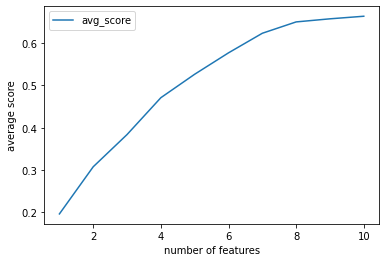

In [ ]:
features_df.plot(y='avg_score')
plt.ylabel('average score')
plt.xlabel('number of features')
plt.show()

The average score increases signficantly as the number of features is increased until around 7/8 features. This implies a lot of the features are meaningful and can be used for classification. For the purpose of this solution, 6 features will be taken foward in case the 7th or 8th feature overfit and only work for the 15 other participants. The 6 taken forward are:

* mfcc
* spec_bw
* rolloff
* zcr
* chroma_stft
* pitch_mean

### Preprocessing for Actual Participants

Having determined which features to take forward, the next step is to extract these features from the audio samples of the original 10 participants.

In [ ]:
def getXy_v2(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file[-11:]
    ypart = list(labels_file[labels_file['File ID']==fileID]['participant'])[0]
    ydig = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    if onlySingleDigit and ydig>9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)

      # 6 features to be taken forward
      mfcc = librosa.feature.mfcc(y=x, sr=fs)
      chroma_stft = librosa.feature.chroma_stft(y=x, sr=fs)
      zcr = librosa.feature.zero_crossing_rate(x)
      rolloff = librosa.feature.spectral_rolloff(y=x, sr=fs)
      spec_bw = librosa.feature.spectral_bandwidth(y=x, sr=fs)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0

      xi = [np.mean(mfcc),np.mean(spec_bw),np.mean(rolloff),np.mean(zcr),np.mean(chroma_stft),pitch_mean]
      X.append(xi)
      y.append(ypart)
  return np.array(X),np.array(y)

Remove audio samples > 3 seconds.

In [ ]:
new_files=shorten(new_files,3)
print(len(new_files))

1069


Get the predictors and labels.

In [ ]:
X,y = getXy_v2(new_files,labels_file=labels,scale_audio=True, onlySingleDigit=False)

100%|██████████| 1069/1069 [04:23<00:00,  4.06it/s]


Encode and display participant labels.

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# transform y to dataframe for encoding
y=pd.DataFrame(y)

# track how encoding mapping looks like
le.fit(y[0])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# add encoded version of participant to dataframe
y['participant_encoded'] = le.fit_transform(y[0])

# select only encoded column
y=y.loc[:,'participant_encoded']

# convert encoded column back to numpy array
y=y.to_numpy()


print('mapping: ',le_name_mapping)
y.shape

mapping:  {'S100': 0, 'S142': 1, 'S161': 2, 'S177': 3, 'S3': 4, 'S5': 5, 'S65': 6, 'S75': 7, 'S87': 8, 'S99': 9}


(1069,)

Normalise X. The goal of data normalisation is to scale the values of the data in a dataset, without distorting said data or losing information. Normalisation is also required for some algorithms to model the data correctly.

In [ ]:
mean = X.mean(0)
sd =  X.std(0)
X_norm = (X-mean)/sd

Split X and y into training and validation subsets.

In [ ]:
from sklearn.model_selection import train_test_split

# split into training and validation subsets
X_train, X_val, y_train, y_val = train_test_split(X_norm,y,test_size=0.3, shuffle=True)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((748, 6), (321, 6), (748,), (321,))

## Models

This section will cover the building, training, and validation of three models on the datasets: a support vector machine, k nearest neighbours and a random forest decision tree. Confusion matrices and receiver operating characteristic (ROC) curves will be used to evaluate the performance of each model. Finally, model accuracies will be compared.

### kNN: K Nearest Neighbours

This is a simple model for both classification and regression problems that uses a similarity metric, for example distance, between samples to classify new samples. The new sample is classified based on the labels of the k nearest neighbouring samples.

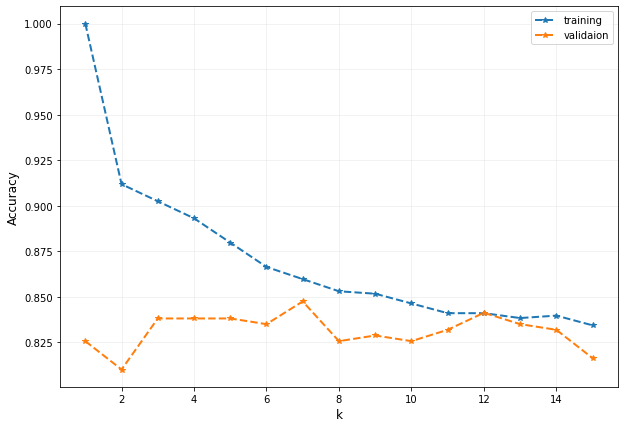

In [ ]:
from sklearn import neighbors

k_values = range(1,16,1)

# create dictionary of accuracy values
accuracy_train = dict.fromkeys(k_values)
accuracy_val = dict.fromkeys(k_values)

for k in k_values:

    # define the kNN model
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # calculate and track the training and validation accuracy
    y_train_pred = knn.predict(X_train)
    accuracy_train[k] = np.mean(y_train==y_train_pred)

    y_val_pred = knn.predict(X_val)
    accuracy_val[k] = np.mean(y_val==y_val_pred)

#plot figure of accuracies
plt.figure(figsize=(10, 7))
plt.plot(k_values, list(accuracy_train.values()), '--*', linewidth=2, label= 'training')
plt.plot(k_values, list(accuracy_val.values()), '--*', linewidth=2, label= 'validaion')
plt.xlabel("k", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(alpha=0.2)
plt.legend(loc='upper right')
plt.show()

While k doesn't seem to make too much of a difference to validation accuracy, interestingly, increasing k decreases the training accuracy. This is because when k=1, the nearest neighbour to each sample is itself, resulting in perfect accuracy. Increasing k can therefore only decrease training accuracy. A k value of 7 gave the best validation accuracy and will be used, although this is probably a result of randomness in the selection of the validation data-subset.

Confusion Matrix

The confusion matrix is a good tool for visualising the rate at which the model is correctly or incorrectly classifying samples. If misclassified, the matrix will show which label the sample was classified as.

The confusion matrices have been normalised across the true labels. This means the values along the diagonal (top left to bottom right) are the true postive rates or sensitivity.

mapping:  {'S100': 0, 'S142': 1, 'S161': 2, 'S177': 3, 'S3': 4, 'S5': 5, 'S65': 6, 'S75': 7, 'S87': 8, 'S99': 9}


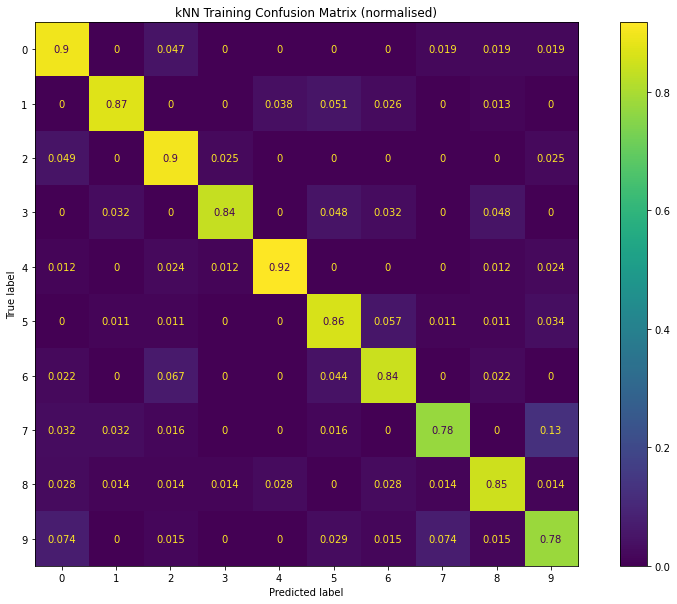

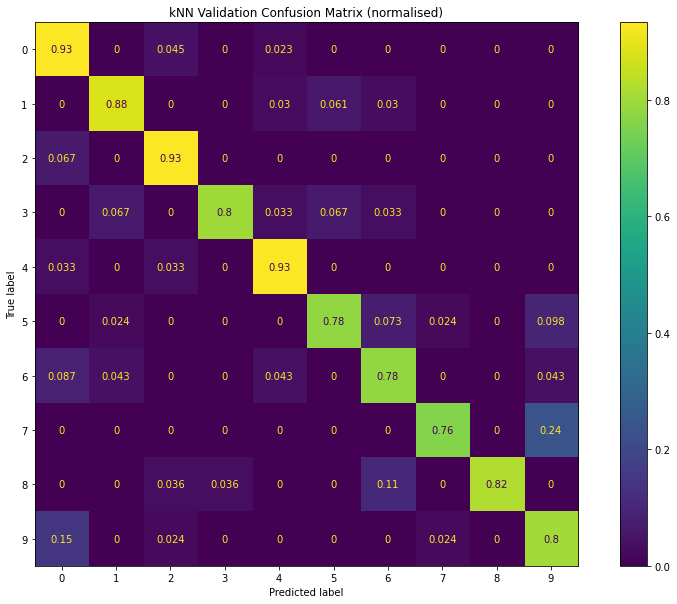

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# label encoding reminder
print('mapping: ', le_name_mapping)

# define and build optimal model
knn_7 = neighbors.KNeighborsClassifier(n_neighbors=7)
knn_7.fit(X_train, y_train)

# plot confusion matrices
fig, ax = plt.subplots(figsize=(15, 10))
plot_confusion_matrix(knn_7, X_train, y_train, normalize='true', ax=ax)
plt.title('kNN Training Confusion Matrix (normalised)')
plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
plot_confusion_matrix(knn_7, X_val, y_val, normalize='true', ax=ax)
plt.title('kNN Validation Confusion Matrix (normalised)')
plt.show()

This model shows excellent true positive rates for both training and validation. The differences in the true positve rates for each label may in part be due to the unbalanced nature of the dataset shown in the visualisation section. This could bias the model towards certain labels, if more data for those label are available. This reasoning applies to all the following models.

ROC

The receiver operating characteristic is a tool for measuring the ability of a model to make a binary classification. Since this is a multi-class problem, the ROC curve will take a one vs rest approach: either a sample is correctly or incorrectly classified. The area under the curve (AUC) shows how well the model performs at discriminating each sample in a binary fashion, with AUC = 1 being the best. The closer the curve is to the diagonal dashed line, the worse the model is at classifying that label, and would be comparible to a model that merely guesses.

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc

def plot_multiclass_roc1(model, X_test, y_test, n_classes, figsize, modeltype):

    # works with rf and kNN
    y_score = model.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC for {modeltype} model')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.3f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="lower right")
    ax.grid(alpha=.4)
    plt.show()

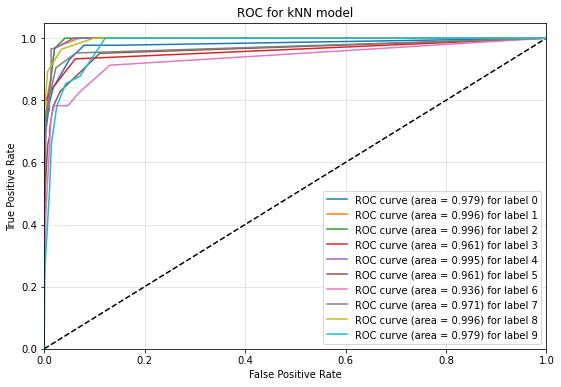

In [ ]:
plot_multiclass_roc1(knn_7, X_val, y_val, n_classes=10, figsize=(9, 6), modeltype='kNN')

This model shows excellent AUCs, all of which are above 0.93

### Support Vector Machine

This first model is a support vector machine (svm), which is a supervised learning method. They are a popular choice for classification and regression problems and perform well in high dimensional spaces, even when the number of dimensions is greater than the number of samples. Here, the svm will be tuned on two hyperperameters.

Tuning gamma as a hyperparameter.

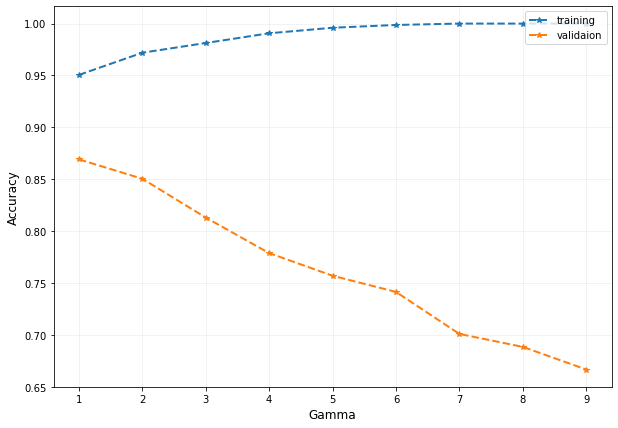

In [ ]:
from sklearn import svm

gamma_values = range(1,10,1)

# create dictionary of accuracy values
accuracy_train = dict.fromkeys(gamma_values)
accuracy_val = dict.fromkeys(gamma_values)

for value in gamma_values:

    # define the svm model - needs to be named differently to svm to prevent overwriting
    svmodel = svm.SVC(C=1,gamma=value)
    svmodel.fit(X_train,y_train)

    # calculate and track the training and validation accuracy
    y_train_pred = svmodel.predict(X_train)
    accuracy_train[value] = np.mean(y_train==y_train_pred)

    y_val_pred = svmodel.predict(X_val)
    accuracy_val[value] = np.mean(y_val==y_val_pred)

#plot figure of accuracies
plt.figure(figsize=(10, 7))
plt.plot(gamma_values, list(accuracy_train.values()), '--*', linewidth=2, label= 'training')
plt.plot(gamma_values, list(accuracy_val.values()), '--*', linewidth=2, label= 'validaion')
plt.xlabel("Gamma", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(alpha=0.2)
plt.legend(loc='upper right')
plt.show()

Increasing gamma decreases the validation accuracy. This is most likely a result of overfitting, hence training accuracy increases with gamma. Gamma = 1 will be taken forward.

Tuning C as a hyperparameter.

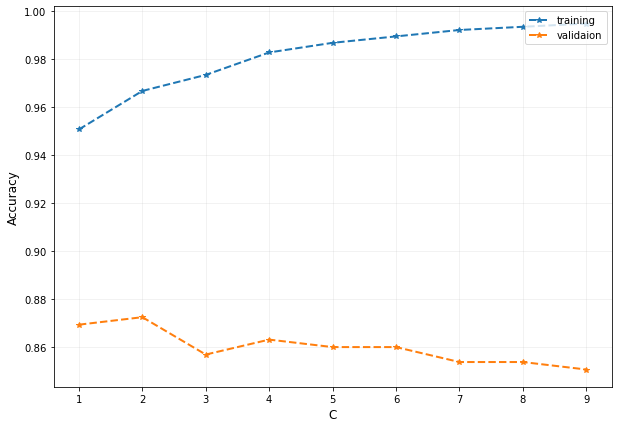

In [ ]:
C_values = range(1,10,1)

# create dictionary of accuracy values
accuracy_train = dict.fromkeys(C_values)
accuracy_val = dict.fromkeys(C_values)

for value in C_values:

    # define the svm model - needs to be named differently to svm to prevent overwriting
    svmodel = svm.SVC(C=value,gamma=1)
    svmodel.fit(X_train,y_train)

    # calculate and track the training and validation accuracy
    y_train_pred = svmodel.predict(X_train)
    accuracy_train[value] = np.mean(y_train==y_train_pred)

    y_val_pred = svmodel.predict(X_val)
    accuracy_val[value] = np.mean(y_val==y_val_pred)

#plot figure of accuracies
plt.figure(figsize=(10, 7))
plt.plot(C_values, list(accuracy_train.values()), '--*', linewidth=2, label= 'training')
plt.plot(C_values, list(accuracy_val.values()), '--*', linewidth=2, label= 'validaion')
plt.xlabel("C", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(alpha=0.2)
plt.legend(loc='upper right')
plt.show()

Increasing C past 2 slowly decreases validation accuracy. Again, this is likely a case of overfitting, hence training accuracy increases. C = 2 will be taken forward.

Confusion Matrix

The confusion matrices have been normalised across the true labels.

mapping:  {'S100': 0, 'S142': 1, 'S161': 2, 'S177': 3, 'S3': 4, 'S5': 5, 'S65': 6, 'S75': 7, 'S87': 8, 'S99': 9}


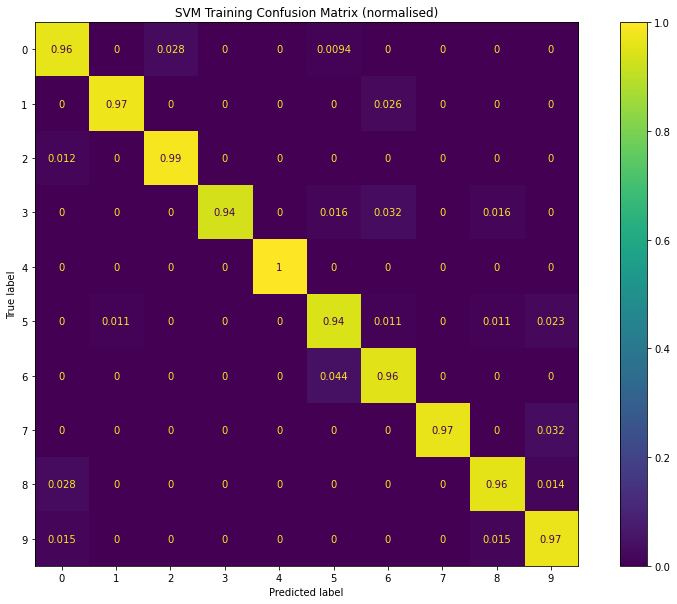

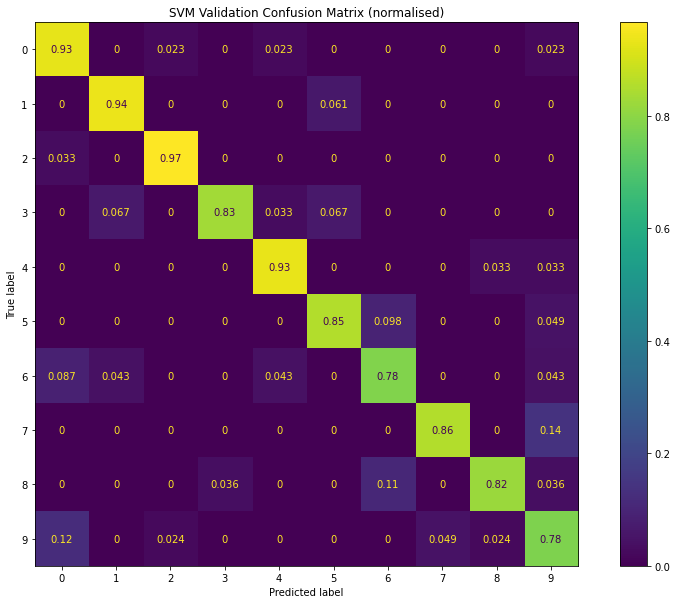

In [ ]:
# label encoding reminder
print('mapping: ', le_name_mapping)

# define and build optimal model
svm_best = svm.SVC(C=2,gamma=1)
svm_best.fit(X_train, y_train)

# plot confusion matrices
fig, ax = plt.subplots(figsize=(15, 10))
plot_confusion_matrix(svm_best, X_train, y_train, normalize='true', ax=ax)
plt.title('SVM Training Confusion Matrix (normalised)')
plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
plot_confusion_matrix(svm_best, X_val, y_val, normalize='true', ax=ax)
plt.title('SVM Validation Confusion Matrix (normalised)')
plt.show()

This model shows excellent true positive rates.

ROC

In [ ]:
def plot_multiclass_roc2(model, X_test, y_test, n_classes, figsize, modeltype):

    # works with svm
    y_score = model.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC for {modeltype} model')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.3f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="lower right")
    ax.grid(alpha=.4)
    plt.show()

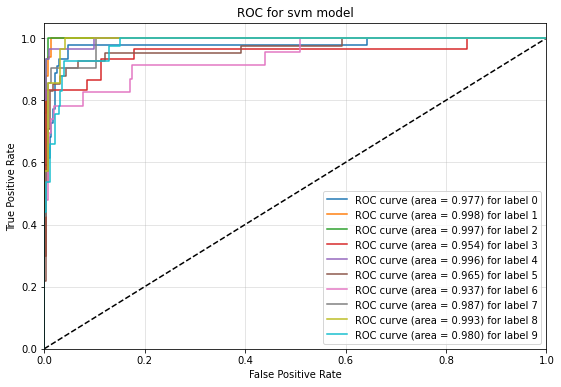

In [ ]:
plot_multiclass_roc2(svm_best, X_val, y_val, n_classes=10, figsize=(9, 6), modeltype= 'svm')

This model shows excellent AUCs, all of which are above 0.93

### Random Forest

Random forest algorithms are ensemble learning methods that build decision trees for classification. They can be prone to overfitting on the training data. Here, one hyperperameter is tuned.

Tuning n estimators/tree depth as a hyperparameter.

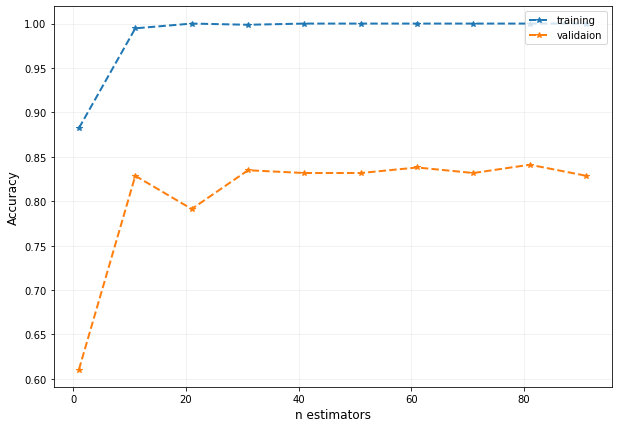

In [ ]:
from sklearn.ensemble import RandomForestClassifier

n_values = range(1,100,10)

# create dictionary of accuracy values
accuracy_train = dict.fromkeys(n_values)
accuracy_val = dict.fromkeys(n_values)

for value in n_values:

    # define the random tree model
    rf = RandomForestClassifier(n_estimators=value)
    rf.fit(X_train, y_train)

    # calculate and track the training and validation accuracy
    y_train_pred = rf.predict(X_train)
    accuracy_train[value] = np.mean(y_train==y_train_pred)

    y_val_pred = rf.predict(X_val)
    accuracy_val[value] = np.mean(y_val==y_val_pred)

#plot figure of accuracies
plt.figure(figsize=(10, 7))
plt.plot(n_values, list(accuracy_train.values()), '--*', linewidth=2, label= 'training')
plt.plot(n_values, list(accuracy_val.values()), '--*', linewidth=2, label= 'validaion')
plt.xlabel("n estimators", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(alpha=0.2)
plt.legend(loc='upper right')
plt.show()

Increasing n estimators initially significantly increases accuracy for both training and validation, but then plateaus for both around n=10. The dip in validation accuracy around n=20 is unexpected and likely due to n=10 providing surprisingly good accuracy, but could also be n=20 providing surprisingly bad accuracy. Training accuracy quickly appraoches 1 with n, demonstrating how this type of model could easily be overfitted. This is not the case here though, as validation accuracy doesn't decrease much past n=30, suggesting no overfitting. n=30 will be taken forward.

Confusion Matrix

mapping:  {'S100': 0, 'S142': 1, 'S161': 2, 'S177': 3, 'S3': 4, 'S5': 5, 'S65': 6, 'S75': 7, 'S87': 8, 'S99': 9}


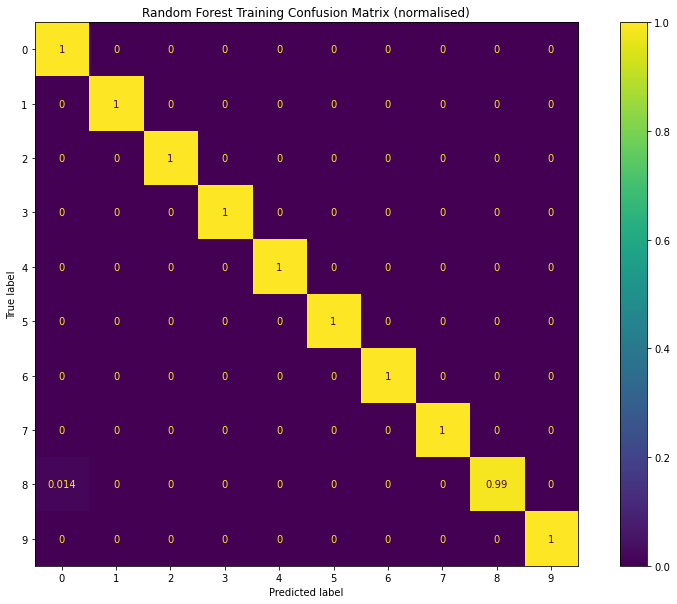

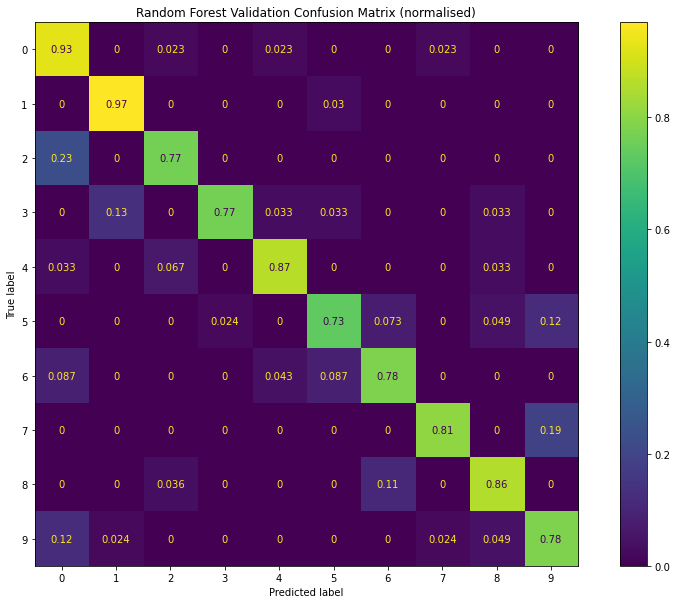

In [ ]:
# label encoding reminder
print('mapping: ', le_name_mapping)

# define and build optimal model
rf_best = RandomForestClassifier(n_estimators=30)
rf_best.fit(X_train, y_train)

# plot confusion matrices
fig, ax = plt.subplots(figsize=(15, 10))
plot_confusion_matrix(rf_best, X_train, y_train, normalize='true', ax=ax)
plt.title('Random Forest Training Confusion Matrix (normalised)')
plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
plot_confusion_matrix(rf_best, X_val, y_val, normalize='true', ax=ax)
plt.title('Random Forest Validation Confusion Matrix (normalised)')
plt.show()

This model shows excellent true positive rates.

ROC

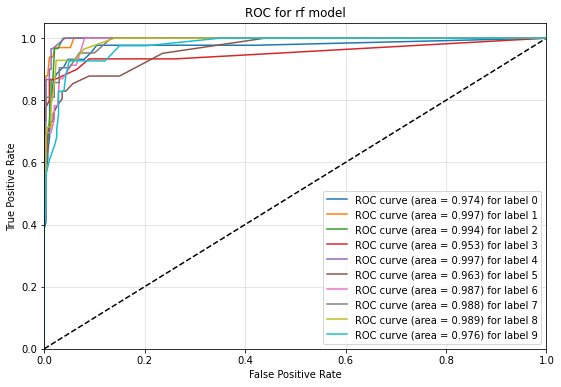

In [ ]:
plot_multiclass_roc1(rf_best, X_val, y_val, n_classes=10, figsize=(9, 6), modeltype='rf')

This models shows excellent AUCs, all of which are above 0.95

### Accuracy Comparison

Compare the overall accuracy of each model.

In [ ]:
# kNN
knnpred_t = knn_7.predict(X_train)
knnpred_v = knn_7.predict(X_val)

print('kNN training accuracy', np.mean(knnpred_t==y_train))
print('kNN validation accuracy', np.mean(knnpred_v==y_val))

# svm
svmpred_t = svm_best.predict(X_train)
svmpred_v = svm_best.predict(X_val)

print('\nSVM training accuracy', np.mean(svmpred_t==y_train))
print('SVM validation accuracy', np.mean(svmpred_v==y_val))

# random forest
rfpred_t = rf_best.predict(X_train)
rfpred_v = rf_best.predict(X_val)

print('\nrf training accuracy', np.mean(rfpred_t==y_train))
print('rf validation accuracy', np.mean(rfpred_v==y_val))



kNN training accuracy 0.8596256684491979
kNN validation accuracy 0.8473520249221184

SVM training accuracy 0.9665775401069518
SVM validation accuracy 0.8722741433021807

rf training accuracy 0.9986631016042781
rf validation accuracy 0.8286604361370716


All models showed excellent training accuracies, all of which were above 85%. Validation accuracies were also really good, all of which were above 82%.  SVM came out on top for validation accuracy. 

## Analysis Summary and Conclusion

This advanced solution has successfully built and trained three models for participant/voice classification. Looking at the confusion matrices and ROC curves and accuracies for all models, it is evident that all provide a very good solution to the classification problem set out at the start. 

All models showed excellent training and validation accuracies. Since the validation accuracies were quite close between the models, the differences may in part be due to the nature of the dataset. Had different participants been selected, the model rankings may have changed. Furthermore, although feature selection was performed and six features taken forward, perhaps a different combination a features, or additional ones, could have benefitted one or all of the models further. Moreover, any audio samples which were not cut correctly could negatively affect training and validation tasks. However, all the validation confusion matrices show that each model had a true positive rate or sensitivity of at least 0.7, and the ROC curves showed area under the curves (AUC) close to 1 (all above 0.9). These are very promising statistics, and reinforce the notion that all three models are very viable. Considering guessing the classification of each sample would yield a ~10% accuracy, all models, on average, performed about 8.5x as well as guessing. This makes sense, as voices can sounds very different to each other, allowing for relatively easy classification. 

